# Planar data classification with one hidden layer

参照资料说明：https://blog.csdn.net/u013733326/article/details/79702148

是时候建立你第一个神经网络，它有一个隐藏层。你会发现这个模型和上一个逻辑回归实现的模型有很大区别

你将学习怎样：

- 构建具有单隐藏层的2类分类神经网络
- 使用具有非线性激活功能激活函数，例如 tanh
- 计算交叉熵损失（损失函数）
- 实现向前和向后传播

## 1 - 软件包

我们需要准备一些软件包：
- numpy：Python进行科学计算的基本软件包
- sklearn：为数据挖掘和数据分析提供的简单高效的工具
- matplotlib：Python中绘制图表的库
- testCases.py：提供了一些测试示例来评估函数的正确性
- planar_utils.py：提供了在这个任务中使用的各种有用的功能

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from testCases import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(1) #设置一个固定的随机种子，以保证接下来的步骤中我们的结果是一致的。

## 2 - 加载数据

首先，我们来看看我们将要使用的数据集，下面的代码会将一个花的图案的2类数据集加载到变量X和Y中

In [3]:
X,Y = load_planar_dataset()

数据集加载完毕，我们可以用matplotlib可视化数据集

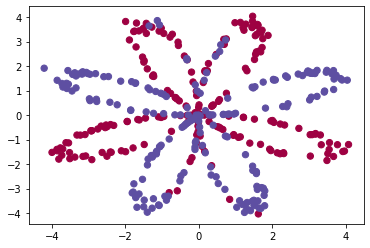

In [4]:
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral) #绘制散点图

上面看起来像一些红色(y = 0)、蓝色(y = 1)的数据点组成的花朵图案，我们的目标是建立一个模型来适应这些数据

现在，我们已经有了：
- X：一个numpy矩阵，包含了这些数据点的数值
- Y：一个numpy向量，对应着X的标签[0|1]（红色：0，蓝色：1）

接下来，我们仔细看这些数据

In [5]:
shape_X = X.shape
shape_Y = Y.shape
m = Y.shape[1]  # 训练集里面的数量

print ("X的维度为: " + str(shape_X))
print ("Y的维度为: " + str(shape_Y))
print ("数据集里面的数据有：" + str(m) + " 个")

X的维度为: (2, 400)
Y的维度为: (1, 400)
数据集里面的数据有：400 个


## 3 - 简易Logistic回归

在构建完整的神经网络之前，先让我们看看逻辑回归在这个问题上的表现如何，我们可以使用sklearn的内置函数来实现，运行下面代码来训练数据集上的逻辑回归分类器

In [6]:
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X.T,Y.T)

C:\Users\20919\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegressionCV()

我们可以把逻辑回归分类器的分类绘制出来

逻辑回归的准确性： 47 % (正确标记的数据点所占的百分比)


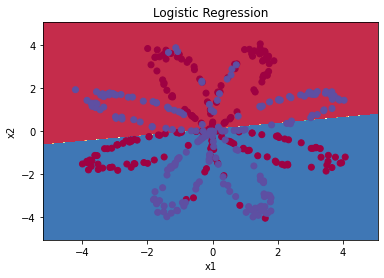

In [7]:
plot_decision_boundary(lambda x: clf.predict(x), X, Y) #绘制决策边界
plt.title("Logistic Regression") #图标题
LR_predictions  = clf.predict(X.T) #预测结果
print ("逻辑回归的准确性： %d " % float((np.dot(Y, LR_predictions) + 
                                np.dot(1 - Y,1 - LR_predictions)) / float(Y.size) * 100) +
       "% " + "(正确标记的数据点所占的百分比)")

解释：准确性只有47%的原因是数据集不是线性可分，故逻辑回归表现不佳，现在我们正式开始构建神经网络

## 4 - 神经网络模型

我们要搭建的神经网络模型如下
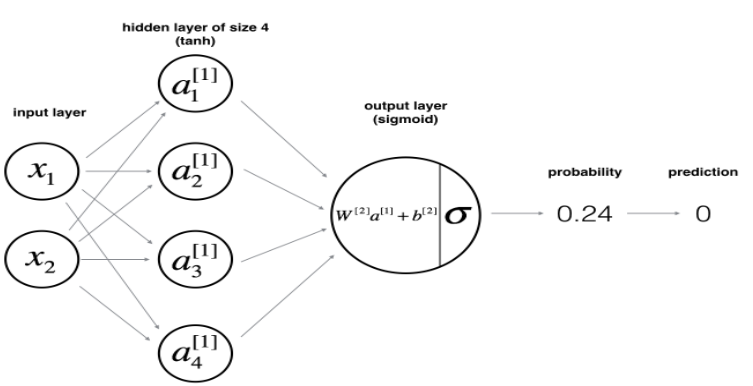


**数学推导**
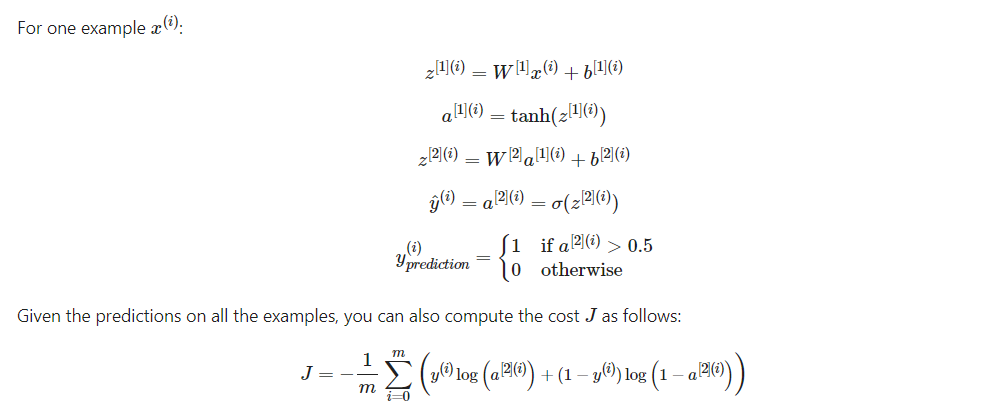

构建神经网络的一般步骤：
- 定义数据网络结构
- 初始化模型参数
- 循环：
    - 实现前向传播
    - 计算损失
    - 实现向后传播
    - 更新参数
    
现在我们要将它们合并到一个nn_model()函数中，当我们构建好了nn_model()并学习了正确的参数，我们就可以预测新的数据

### 4.1 - 定义神经网络结构

在构建之前，先定义三个变量
- n_x：输入层数量
- n_h：隐藏层数量（这里设置为4）
- n_y：输出层数量

In [9]:
def layer_sizes(X , Y):
    """
    参数：
     X - 输入数据集,维度为（输入的数量，训练/测试的数量）
     Y - 标签，维度为（输出的数量，训练/测试数量）
    
    返回：
     n_x - 输入层的数量
     n_h - 隐藏层的数量
     n_y - 输出层的数量
    """
    n_x = X.shape[0] #输入层
    n_h = 4 #，隐藏层，硬编码为4
    n_y = Y.shape[0] #输出层
    
    return (n_x,n_h,n_y)

In [10]:
#测试layer_sizes
print("=========================测试layer_sizes=========================")
X_asses , Y_asses = layer_sizes_test_case()
(n_x,n_h,n_y) =  layer_sizes(X_asses,Y_asses)
print("输入层的节点数量为: n_x = " + str(n_x))
print("隐藏层的节点数量为: n_h = " + str(n_h))
print("输出层的节点数量为: n_y = " + str(n_y))

=========================测试layer_sizes=========================
输入层的节点数量为: n_x = 5
隐藏层的节点数量为: n_h = 4
输出层的节点数量为: n_y = 2


### 4.2 - 初始化模型参数

实现函数initialize_parameters(),我们要确保我们的参数大小合适，若需要的话，请参考上面的神经网络图

我们将用随机值初始化权重矩阵
- np.random.randn(a，b)* 0.01：来随机初始化一个维度为(a,b)的矩阵
将偏向量初始化为零
- np.zeros((a，b))：初始化矩阵(a,b)

In [11]:
def initialize_parameters( n_x , n_h ,n_y):
    """
    参数：
        n_x - 输入层节点的数量
        n_h - 隐藏层节点的数量
        n_y - 输出层节点的数量
    
    返回：
        parameters - 包含参数的字典：
            W1 - 权重矩阵,维度为（n_h，n_x）
            b1 - 偏向量，维度为（n_h，1）
            W2 - 权重矩阵，维度为（n_y，n_h）
            b2 - 偏向量，维度为（n_y，1）

    """
    np.random.seed(2) #指定一个随机种子，以便你的输出与我们的一样。
    W1 = np.random.randn(n_h,n_x) * 0.01
    b1 = np.zeros(shape=(n_h, 1))
    W2 = np.random.randn(n_y,n_h) * 0.01
    b2 = np.zeros(shape=(n_y, 1))
    
    #使用断言确保我的数据格式是正确的
    assert(W1.shape == ( n_h , n_x ))
    assert(b1.shape == ( n_h , 1 ))
    assert(W2.shape == ( n_y , n_h ))
    assert(b2.shape == ( n_y , 1 ))
    
    parameters = {"W1" : W1,
	              "b1" : b1,
	              "W2" : W2,
	              "b2" : b2 }
    
    return parameters

In [12]:
#测试initialize_parameters
print("=========================测试initialize_parameters=========================")    
n_x , n_h , n_y = initialize_parameters_test_case()
parameters = initialize_parameters(n_x , n_h , n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

=========================测试initialize_parameters=========================
W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]


### 4.3 循环

问题：实现前向传播函数 'forward_propagation()'

你可以使用sigmoid()，也可以使用np.tanh()

步骤如下：
- 使用字典类型的parameter(它是initialize_parameters()的输出)检索每个参数
- 实现前向传播，计算$Z^{[1]},A^{[1]},Z^{[2]},A^{[2}$(训练集里面所有例子的预测向量)
- 反向传播所需的值存储在‘cache’中，cache将作为反向传播函数的输入

In [13]:
def forward_propagation( X , parameters ):
    """
    参数：
         X - 维度为（n_x，m）的输入数据。
         parameters - 初始化函数（initialize_parameters）的输出
    
    返回：
         A2 - 使用sigmoid()函数计算的第二次激活后的数值
         cache - 包含“Z1”，“A1”，“Z2”和“A2”的字典类型变量
     """
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    #前向传播计算A2
    Z1 = np.dot(W1 , X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2 , A1) + b2
    A2 = sigmoid(Z2)
    #使用断言确保我的数据格式是正确的
    assert(A2.shape == (1,X.shape[1]))
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return (A2, cache)

In [14]:
#测试forward_propagation
print("=========================测试forward_propagation=========================") 
X_assess, parameters = forward_propagation_test_case()
A2, cache = forward_propagation(X_assess, parameters)
print(np.mean(cache["Z1"]), np.mean(cache["A1"]), np.mean(cache["Z2"]), np.mean(cache["A2"]))

=========================测试forward_propagation=========================
-0.0004997557777419902 -0.000496963353231779 0.00043818745095914653 0.500109546852431


现在我们已经计算了$A^{[2]},a^{[2](i)}$，包含了训练集里的每个数值，现在我们就可以构建成本函数

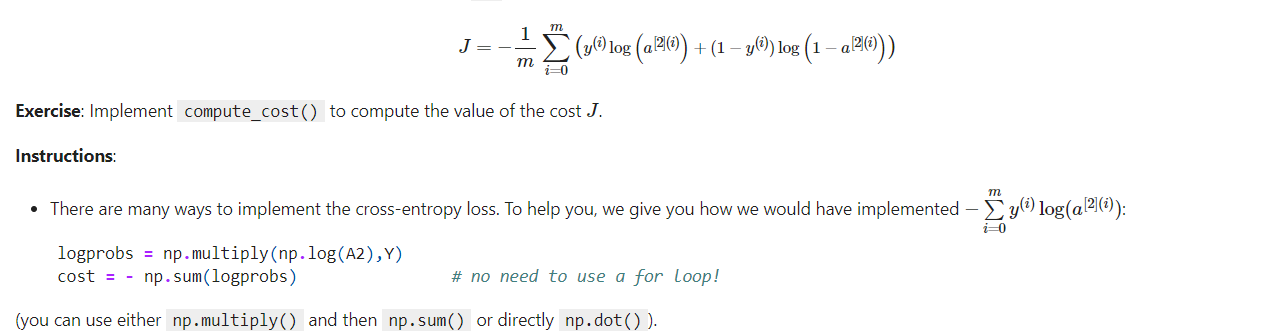

In [15]:
def compute_cost(A2,Y,parameters):
    """    
    参数：
         A2 - 使用sigmoid()函数计算的第二次激活后的数值
         Y - "True"标签向量,维度为（1，数量）
         parameters - 一个包含W1，B1，W2和B2的字典类型的变量
    
    返回：
         成本 - 交叉熵成本给出方程
    """
    
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    #计算成本
    logprobs = logprobs = np.multiply(np.log(A2), Y) + np.multiply((1 - Y), np.log(1 - A2))
    cost = - np.sum(logprobs) / m
    cost = float(np.squeeze(cost))
    
    assert(isinstance(cost,float))
    
    return cost

In [16]:
#测试compute_cost
print("=========================测试compute_cost=========================") 
A2 , Y_assess , parameters = compute_cost_test_case()
print("cost = " + str(compute_cost(A2,Y_assess,parameters)))

=========================测试compute_cost=========================
cost = 0.6929198937761266


使用正向传播期间计算的cache，现在可以利用它实现反向传播

说明：反向传播通常是深度学习中最难（数学意义）部分，为了帮助你，这里有反向传播讲座的幻灯片， 由于我们正在构建向量化实现，因此我们将需要使用这下面的六个方程：
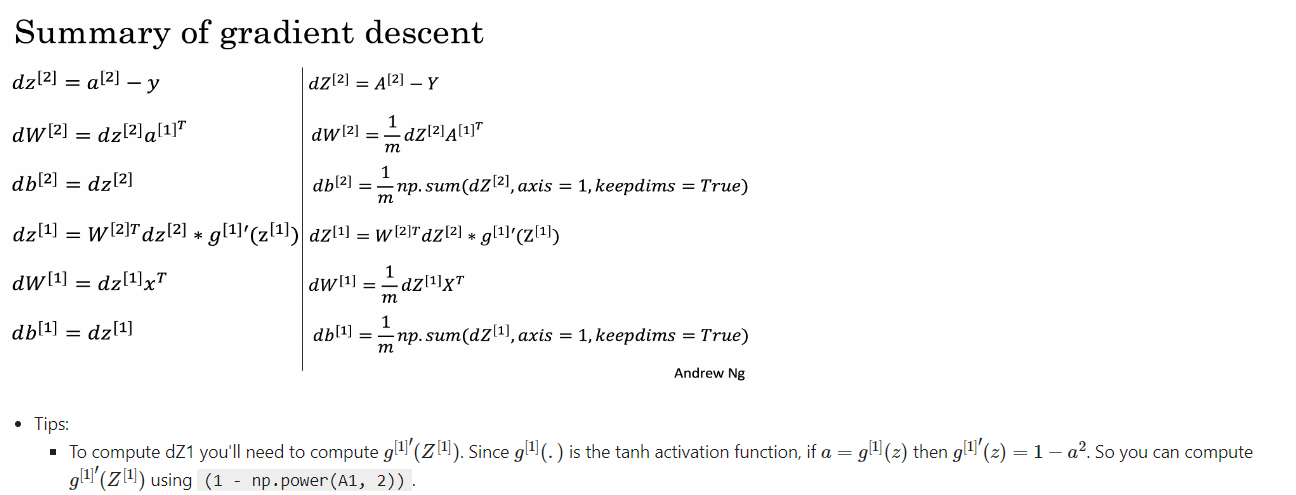

In [17]:
def backward_propagation(parameters,cache,X,Y):
    """
    使用上述说明搭建反向传播函数。
    
    参数：
     parameters - 包含我们的参数的一个字典类型的变量。
     cache - 包含“Z1”，“A1”，“Z2”和“A2”的字典类型的变量。
     X - 输入数据，维度为（2，数量）
     Y - “True”标签，维度为（1，数量）
    
    返回：
     grads - 包含W和b的导数一个字典类型的变量。
    """
    m = X.shape[1]
    
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    dZ2= A2 - Y
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1, 2))
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2 }
    
    return grads

In [18]:
#测试backward_propagation
print("=========================测试backward_propagation=========================")
parameters, cache, X_assess, Y_assess = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, X_assess, Y_assess)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

=========================测试backward_propagation=========================
dW1 = [[ 0.01018708 -0.00708701]
 [ 0.00873447 -0.0060768 ]
 [-0.00530847  0.00369379]
 [-0.02206365  0.01535126]]
db1 = [[-0.00069728]
 [-0.00060606]
 [ 0.000364  ]
 [ 0.00151207]]
dW2 = [[ 0.00363613  0.03153604  0.01162914 -0.01318316]]
db2 = [[0.06589489]]


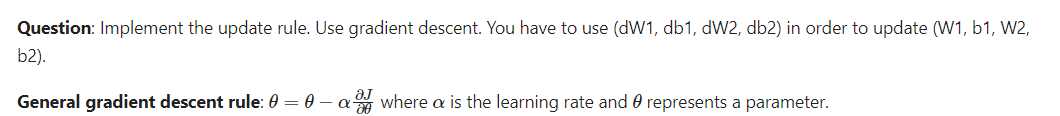


In [19]:
def update_parameters(parameters,grads,learning_rate=1.2):
    """
    使用上面给出的梯度下降更新规则更新参数
    
    参数：
     parameters - 包含参数的字典类型的变量。
     grads - 包含导数值的字典类型的变量。
     learning_rate - 学习速率
    
    返回：
     parameters - 包含更新参数的字典类型的变量。
    """
    W1,W2 = parameters["W1"],parameters["W2"]
    b1,b2 = parameters["b1"],parameters["b2"]
    
    dW1,dW2 = grads["dW1"],grads["dW2"]
    db1,db2 = grads["db1"],grads["db2"]
    
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [20]:
#测试update_parameters
print("=========================测试update_parameters=========================")
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

=========================测试update_parameters=========================
W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]


### 4.4 - 整合上面函数到nn_model()中

In [21]:
def nn_model(X,Y,n_h,num_iterations,print_cost=False):
    """
    参数：
        X - 数据集,维度为（2，示例数）
        Y - 标签，维度为（1，示例数）
        n_h - 隐藏层的数量
        num_iterations - 梯度下降循环中的迭代次数
        print_cost - 如果为True，则每1000次迭代打印一次成本数值
    
    返回：
        parameters - 模型学习的参数，它们可以用来进行预测。
     """
     
    np.random.seed(3) #指定随机种子
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    parameters = initialize_parameters(n_x,n_h,n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    for i in range(num_iterations):
        A2 , cache = forward_propagation(X,parameters)
        cost = compute_cost(A2,Y,parameters)
        grads = backward_propagation(parameters,cache,X,Y)
        parameters = update_parameters(parameters,grads,learning_rate = 0.5)
        
        if print_cost:
            if i%1000 == 0:
                print("第 ",i," 次循环，成本为："+str(cost))
    return parameters

In [22]:
#测试nn_model
print("=========================测试nn_model=========================")
X_assess, Y_assess = nn_model_test_case()

parameters = nn_model(X_assess, Y_assess, 4, num_iterations=10000, print_cost=False)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

=========================测试nn_model=========================


C:\Users\20919\AppData\Local\Temp\ipykernel_14848\1056308202.py:19: RuntimeWarning: divide by zero encountered in log
  logprobs = logprobs = np.multiply(np.log(A2), Y) + np.multiply((1 - Y), np.log(1 - A2))
C:\Users\20919\PycharmProjects\wuenda-DeepLearning\course1\Thrid\planar_utils.py:31: RuntimeWarning: overflow encountered in exp
  s = 1/(1+np.exp(-x))


W1 = [[-3.89167767  4.77541602]
 [-6.77960338  1.20272585]
 [-3.88338966  4.78028666]
 [ 6.77958203 -1.20272574]]
b1 = [[ 2.11530892]
 [ 3.41221357]
 [ 2.11585732]
 [-3.41221322]]
W2 = [[-2512.9093032  -2502.70799785 -2512.01655969  2502.65264416]]
b2 = [[-22.29071761]]


### 4.5 - 预测
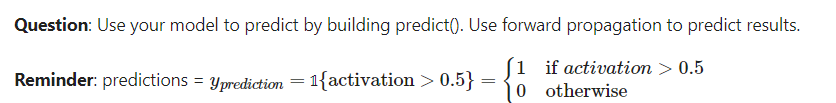

In [24]:
def predict(parameters,X):
    """
    使用学习的参数，为X中的每个示例预测一个类
    
    参数：
		parameters - 包含参数的字典类型的变量。
	    X - 输入数据（n_x，m）
    
    返回
		predictions - 我们模型预测的向量（红色：0 /蓝色：1）
     
     """
    A2 , cache = forward_propagation(X,parameters)
    predictions = np.round(A2)
    
    return predictions

In [25]:
#测试predict
print("=========================测试predict=========================")

parameters, X_assess = predict_test_case()

predictions = predict(parameters, X_assess)
print("预测的平均值 = " + str(np.mean(predictions)))

=========================测试predict=========================
预测的平均值 = 0.6666666666666666


是时候运行我们的模型去预测上面“花”数据集了

第  0  次循环，成本为：0.6930480201239823
第  1000  次循环，成本为：0.3098018601352803
第  2000  次循环，成本为：0.2924326333792646
第  3000  次循环，成本为：0.2833492852647412
第  4000  次循环，成本为：0.27678077562979253
第  5000  次循环，成本为：0.26347155088593144
第  6000  次循环，成本为：0.24204413129940763
第  7000  次循环，成本为：0.23552486626608762
第  8000  次循环，成本为：0.23140964509854278
第  9000  次循环，成本为：0.22846408048352365
准确率: 90%


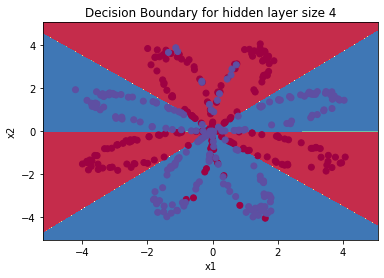

In [26]:
parameters = nn_model(X, Y, n_h = 4, num_iterations=10000, print_cost=True)

#绘制边界
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

predictions = predict(parameters, X)
print ('准确率: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')

### 4.6 - 更改隐藏层节点数量
我们上面的实验把隐藏层定为4个节点，现在我们更改隐藏层里面的节点数量，看一看节点数量是否会对结果造成影响

隐藏层的节点数量： 1  ，准确率: 67.25 %
隐藏层的节点数量： 2  ，准确率: 66.5 %
隐藏层的节点数量： 3  ，准确率: 89.25 %
隐藏层的节点数量： 4  ，准确率: 90.0 %
隐藏层的节点数量： 5  ，准确率: 89.75 %
隐藏层的节点数量： 20  ，准确率: 90.0 %
隐藏层的节点数量： 50  ，准确率: 89.75 %


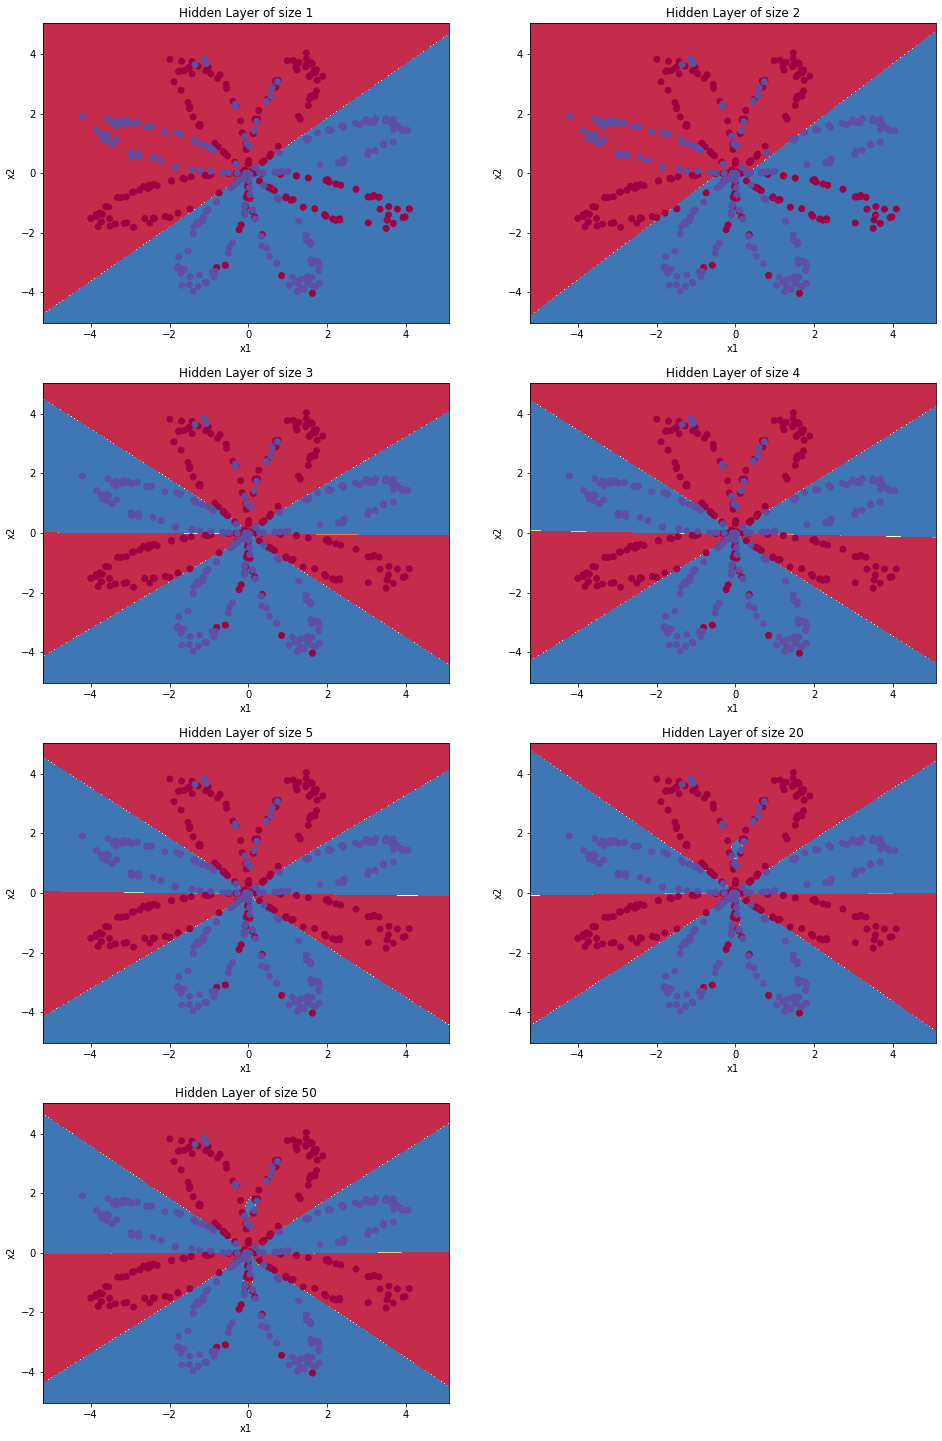

In [27]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50] #隐藏层数量
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i + 1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations=5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100)
    print ("隐藏层的节点数量： {}  ，准确率: {} %".format(n_h, accuracy))

解释：
- 较大的模型（具有更多隐藏单元）能够更好地适应训练集，直到最终的最大模型过度拟合数据
- 最好的隐藏层大小似乎在n_h = 5附近。实际上，这里的值似乎很适合数据，而且不会引起过度拟合
- 我们还将在后面学习有关正则化的知识，它允许我们使用非常大的模型（如n_h = 50），而不会出现太多过度拟合

## 5 - 预测其他的数据集

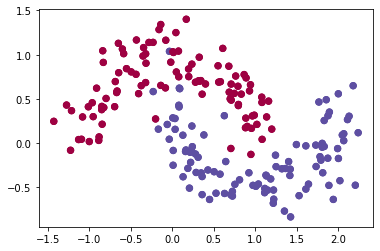

In [28]:
# 数据集
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

dataset = "noisy_moons"

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

if dataset == "blobs":
    Y = Y % 2

plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral)

#上一语句如出现问题请使用下面的语句：
plt.scatter(X[0, :], X[1, :], c=np.squeeze(Y), s=40, cmap=plt.cm.Spectral)